In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate some data

In [2]:
np.random.seed(666)
n_cycles = 20

df = pd.DataFrame({
    'ds': list(range(7 * n_cycles)),
    'y': [5, 2, 1, 1, 1, 2, 5] * n_cycles + np.random.normal(size=7 * n_cycles)
})

df.head()

,ds,y
0,0,5.824188
1,1,2.479966
2,2,2.173468
3,3,1.909048
4,4,0.428279


<AxesSubplot:xlabel='ds', ylabel='y'>

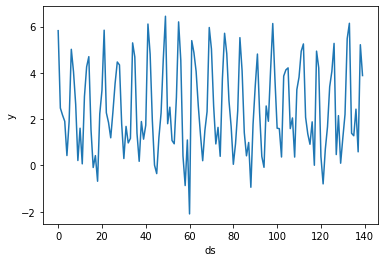

In [3]:
# Plot
sns.lineplot(data=df, x='ds', y='y')

<AxesSubplot:xlabel='ds', ylabel='y'>

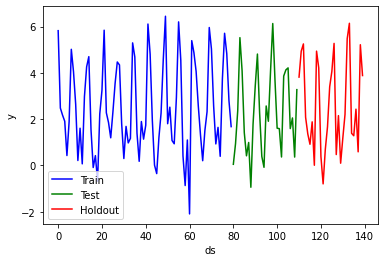

In [4]:
# Let's split into train/test/holdout
train = df[df.ds < 80]
test = df[(80 <= df.ds) & (df.ds < 110)]
holdout = df[110 <= df.ds]

# Plot
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')
sns.lineplot(data=holdout, x='ds', y='y', color='red', label='Holdout')

# Simple model: Use "today" to predict future values

In [5]:
latest_value = float(train.loc[train.ds == train.ds.max(), 'y'])
latest_value

1.6777550912723194

In [6]:
fc_test_simple = test[['ds']].copy()
fc_test_simple['y'] = latest_value

fc_test_simple

,ds,y
80,80,1.677755
81,81,1.677755
82,82,1.677755
83,83,1.677755
84,84,1.677755
85,85,1.677755
86,86,1.677755
87,87,1.677755
88,88,1.677755
89,89,1.677755


<AxesSubplot:xlabel='ds', ylabel='y'>

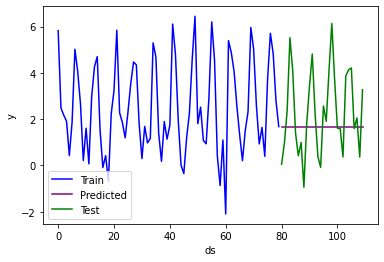

In [7]:
# Plot
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=fc_test_simple, x='ds', y='y', color='purple', label='Predicted')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')

<AxesSubplot:xlabel='ds', ylabel='y'>

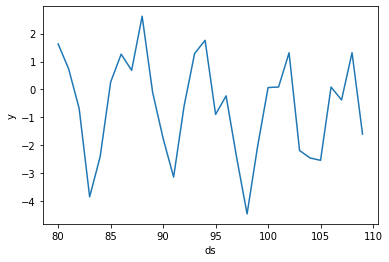

In [8]:
# Plot residuals
sns.lineplot(
    x=fc_test_simple['ds'],
    y=fc_test_simple['y'].subtract(test['y']),
)

# Since there seems to be a pattern, let's instead do a simple "lagged" model

Use the autocorrelation to determine the best "lags" to use.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

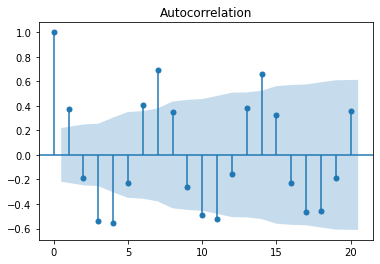

In [10]:
plot_acf(train['y'])
plt.show()

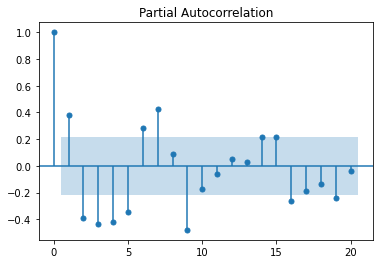

In [11]:
plot_pacf(train['y'])
plt.show()

Highest lags seem to be:

- 1 (positive), already tried
- 4 (negative)
- 7 (positive)

Let's test a few models that simply pass forward these lagged values

In [12]:
from copy import deepcopy
def get_lagged_forecasts(x, l, n):
    '''
    x: List-like object to initialize forecasts
    l: Lag to use
    n: Number of times to forecast
    '''
    fc = deepcopy(x)
    for i in range(n):
        fc.append(fc[-l])
    return fc[len(x):]

# Some tests
assert get_lagged_forecasts([1, 2, 3, 4, 5], l=1, n=1) == [5]
assert get_lagged_forecasts([1, 2, 3, 4, 5], l=1, n=5) == [5, 5, 5, 5, 5]
assert get_lagged_forecasts([1, 2, 3, 4, 5], l=2, n=5) == [4, 5, 4, 5, 4]
assert get_lagged_forecasts([1, 2, 3, 4, 5], l=5, n=5) == [1, 2, 3, 4, 5]

In [13]:
fc_test_lags = test[['ds']].copy()
fc_test_lags['y_p4'] = get_lagged_forecasts(list(train['y']), l=4, n=test.shape[0])
fc_test_lags['y_p7'] = get_lagged_forecasts(list(train['y']), l=7, n=test.shape[0])

# Inspect
fc_test_lags.head(10)

,ds,y_p4,y_p7
80,80,5.711504,1.645495
81,81,4.829350,0.394410
82,82,2.800130,3.739251
83,83,1.677755,5.711504
84,84,5.711504,4.829350
85,85,4.829350,2.800130
86,86,2.800130,1.677755
87,87,1.677755,1.645495
88,88,5.711504,0.394410
89,89,4.829350,3.739251


<AxesSubplot:xlabel='ds', ylabel='y'>

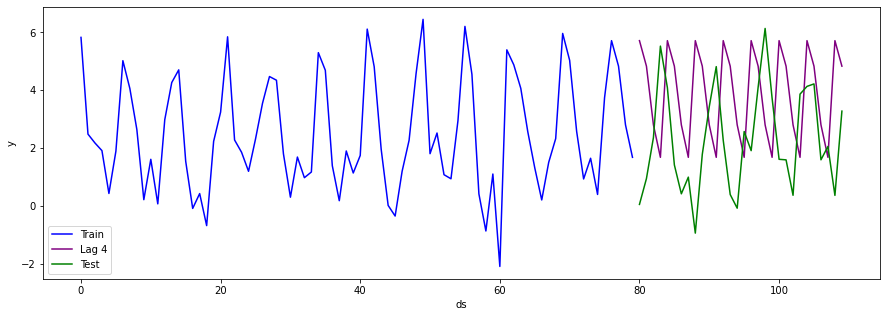

In [14]:
# Plot lag 4
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=fc_test_lags, x='ds', y='y_p4', color='purple', label='Lag 4')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')

<AxesSubplot:xlabel='ds', ylabel='y'>

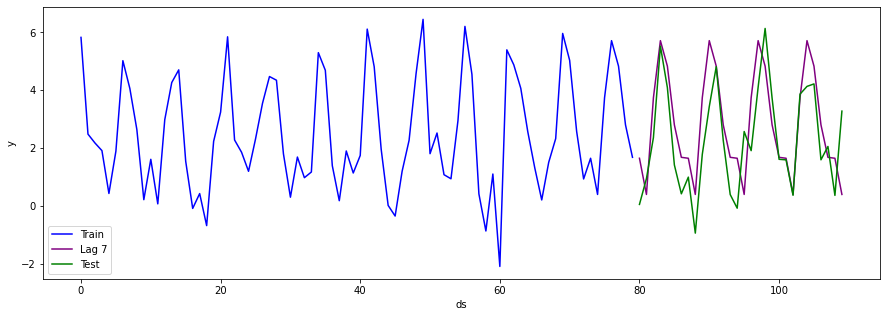

In [15]:
# Plot lag 7
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=fc_test_lags, x='ds', y='y_p7', color='purple', label='Lag 7')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')

<AxesSubplot:xlabel='ds'>

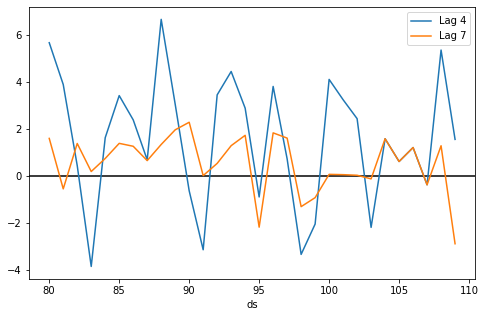

In [16]:
# Plot residuals
plt.figure(figsize=(8, 5))
plt.axhline(0, color='black')
sns.lineplot(
    x=fc_test_lags['ds'],
    y=fc_test_lags['y_p4'].subtract(test['y']),
    label='Lag 4'
)
sns.lineplot(
    x=fc_test_lags['ds'],
    y=fc_test_lags['y_p7'].subtract(test['y']),
    label='Lag 7'
)

C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

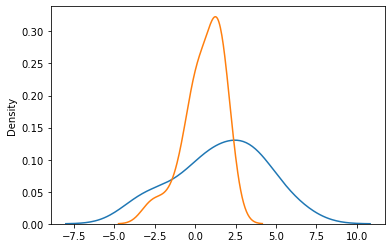

In [17]:
# Distribution of residuals
sns.distplot(fc_test_lags['y_p4'].subtract(test['y']), hist=False, label='Lag 4')
sns.distplot(fc_test_lags['y_p7'].subtract(test['y']), hist=False, label='Lag 7')

Lag 7 has much cleaner looking residuals (i.e. more centered around 0, smaller variance)

# Let's try building a simple seasonal ARIMA model

We'll test a few alternatives to see which looks best on the test data using AIC.

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
# Start with a simple model: Non-seasonal 1 AR, Seasonal-7 1 AR
arima_100_7100 = ARIMA(train['y'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 7)).fit()

# Print summary
arima_100_7100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                   80
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                -137.627
Date:                         Tue, 10 Nov 2020   AIC                            283.254
Time:                                 23:18:01   BIC                            292.782
Sample:                                      0   HQIC                           287.074
                                          - 80                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6138      0.484      5.395      0.000       1.664       3.563
ar.L1          0.0155      0.112      0.138      0.890      -0.205       0.236
ar.S.L7        0.7332      0.074      9.919      0.000       0.588       0.878
sigma2         1.7080      0.285      5.996      0.000       1.150       2.266
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.81   Prob(JB):                         0.74
Heteroskedasticity (H):               1.87   Skew:                            -0.19
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='ds', ylabel='y'>

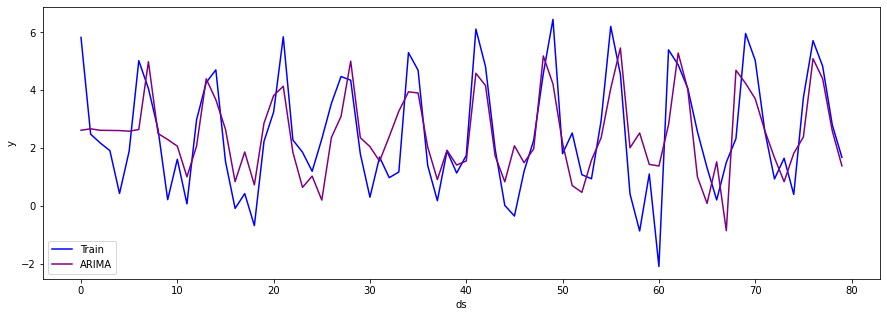

In [20]:
# Plot on train
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(x=train['ds'], y=arima_100_7100.predict(), color='purple', label='ARIMA')

<AxesSubplot:xlabel='ds', ylabel='y'>

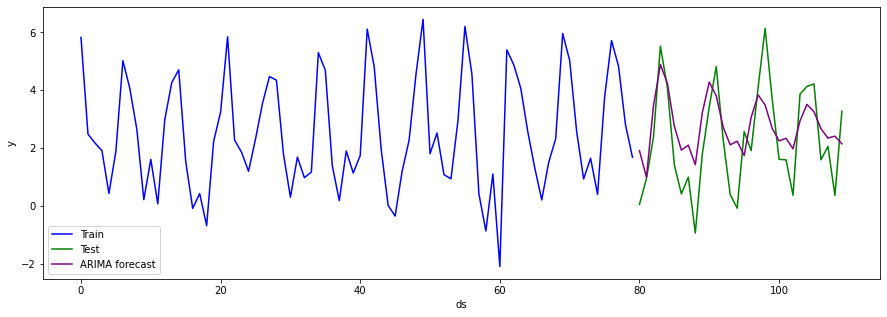

In [21]:
# Forecast on test
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')
sns.lineplot(x=test['ds'], y=arima_100_7100.forecast(test.shape[0]), color='purple', label='ARIMA forecast')

<AxesSubplot:xlabel='ds', ylabel='y'>

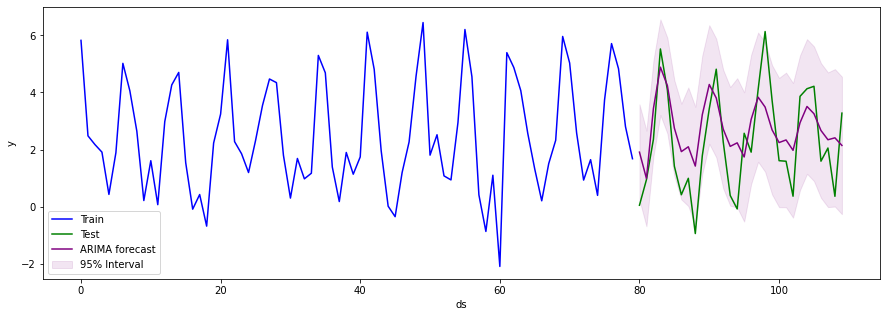

In [22]:
# Forecast on test with prediction intervals
arima_100_7100_fc = arima_100_7100.get_forecast(steps=test.shape[0]).summary_frame(alpha=0.20).reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')
plt.fill_between(
    x=arima_100_7100_fc['index'],
    y1=arima_100_7100_fc['mean_ci_lower'],
    y2=arima_100_7100_fc['mean_ci_upper'],
    color='purple',
    label='95% Interval',
    alpha=0.1
)
sns.lineplot(data=arima_100_7100_fc, x='index', y='mean', color='purple', label='ARIMA forecast')

Now let's try an "auto arima" type approach where we span parameter sets.

- Non-seasonal:
    - AR: 0-3
    - I: 0-3
    - MA: 0-3
- Seasonal:
    - AR 0-3
    - I: 0-3
    - MA: 0-3

In [23]:
ns_ar = [0, 1, 2, 3]
ns_i = [0, 1, 2]
ns_ma = [0, 1, 2, 3]

s_ar = [0, 1, 2]
s_i = [0, 1, 2]
s_ma = [0, 1, 2]

In [24]:
from itertools import product

search_again = False

if search_again:
    hp_sets = list(product(ns_ar, ns_i, ns_ma, s_ar, s_i, s_ma))
else:
    hp_sets = [(3, 0, 3, 1, 1, 1)]

len(hp_sets)

1

In [25]:
import sys

arima_models = []
for _ns_ar, _ns_i, _ns_ma, _s_ar, _s_i, _s_ma in hp_sets:
    # Print status
    print(f'Fitting ({_ns_ar}, {_ns_i}, {_ns_ma}) 7({_s_ar}, {_s_i}, {_s_ma})')
    
    # Initialize gbm
    try:
        arima = ARIMA(
            train['y'],
            order=(_ns_ar, _ns_i, _ns_ma),
            seasonal_order=(_s_ar, _s_i, _s_ma, 7)
        ).fit()
    except Exception as inst:
        print(f'    Unexpected Error: {inst}, {sys.exc_info()[0]}')
        continue

    # Save the score means and standard deviations
    arima_models += [
        ((_ns_ar, _ns_i, _ns_ma, _s_ar, _s_i, _s_ma), arima)
    ]
    
    del arima, _ns_ar, _ns_i, _ns_ma

Fitting (3, 0, 3) 7(1, 1, 1)


C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [26]:
# Get parameter sets for the best 10% of models
top10p_aicc = sorted([x[1].aicc for x in arima_models])[round(len(arima_models) / 10)]

top10p_arima_models = [x for x in arima_models if x[1].aicc <= top10p_aicc]

In [27]:
top10p_arima_models

[((3, 0, 3, 1, 1, 1),
  <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0xc5c2cc8>)]

In [28]:
# Get test set MAE
arima_models_maes = []
for hps, _arima_model in top10p_arima_models:
    # Print status
    print(f'Forecasting {hps}')
    
    # Forecast
    _fc = _arima_model.forecast(steps=test.shape[0])
    
    # Get MAE
    _mae = abs(_fc.subtract(test['y'])).mean()

    # Save the score means and standard deviations
    arima_models_maes += [
        (hps, _arima_model, _mae)
    ]
    
    del hps, _arima_model, _mae, _fc

Forecasting (3, 0, 3, 1, 1, 1)


In [29]:
# Get the model with the minimum MAE
best_arima_by_mae = [
    x for x in arima_models_maes
    if x[2] == min([y[2] for y in arima_models_maes])
][0]

best_arima_by_mae

((3, 0, 3, 1, 1, 1),
 0.8581973200003077)

In [30]:
# Summarize model
best_arima_by_mae[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   80
Model:             ARIMA(3, 0, 3)x(1, 1, [1], 7)   Log Likelihood                -102.926
Date:                           Tue, 10 Nov 2020   AIC                            223.853
Time:                                   23:18:03   BIC                            244.467
Sample:                                        0   HQIC                           232.068
                                            - 80                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2341      0.235     -0.994      0.320      -0.696       0.227
ar.L2         -0.0023      0.197     -0.012      0.991      -0.389       0.384
ar.L3         -0.7305      0.161     -4.533      0.000      -1.046      -0.415
ma.L1          0.1847      0.211      0.875      0.382      -0.229       0.598
ma.L2          0.2106      0.210      1.003      0.316      -0.201       0.622
ma.L3          0.9397      0.248      3.783      0.000       0.453       1.427
ar.S.L7       -0.0922      0.188     -0.490      0.624      -0.461       0.276
ma.S.L7       -0.9215      0.408     -2.257      0.024      -1.722      -0.121
sigma2         0.8093      0.331      2.444      0.015       0.160       1.458
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.70   Prob(JB):                         0.66
Heteroskedasticity (H):               1.80   Skew:                             0.04
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='ds', ylabel='y'>

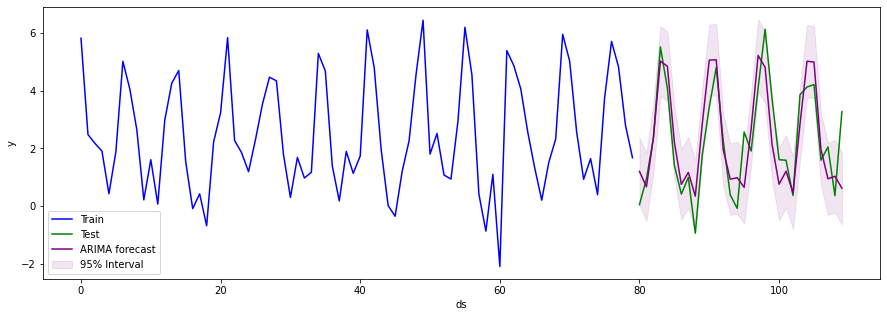

In [31]:
# Plot with prediction intervals
best_arima_by_mae_fc = best_arima_by_mae[1].get_forecast(steps=test.shape[0]).summary_frame(alpha=0.20)
best_arima_by_mae_fc['ds'] = best_arima_by_mae_fc.index

plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')
plt.fill_between(
    x=best_arima_by_mae_fc['ds'],
    y1=best_arima_by_mae_fc['mean_ci_lower'],
    y2=best_arima_by_mae_fc['mean_ci_upper'],
    color='purple',
    label='95% Interval',
    alpha=0.1
)
sns.lineplot(data=best_arima_by_mae_fc, x='ds', y='mean', color='purple', label='ARIMA forecast')

C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

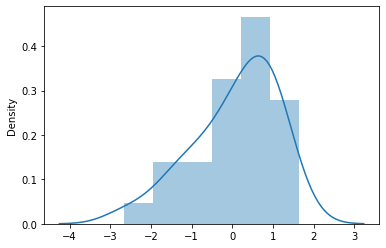

In [32]:
# Distribution of residuals
sns.distplot(best_arima_by_mae_fc['mean'].subtract(test['y']))

Slight positive bias above zero

# Let's try building a simple Prophet model

Need to make "ds" a date field, so will arbitrarily set it to start on Jan 1, 2020

In [33]:
from fbprophet import Prophet
from datetime import datetime, timedelta

Importing plotly failed. Interactive plots will not work.


In [34]:
train_copy = deepcopy(train)

train_copy['ds'] = train_copy['ds'].apply(
    lambda x: datetime.strptime('2020-01-01', '%Y-%m-%d') + timedelta(days=x)
)

# Inspect
train_copy

,ds,y
0,2020-01-01,5.824188
1,2020-01-02,2.479966
2,2020-01-03,2.173468
3,2020-01-04,1.909048
4,2020-01-05,0.428279
...,...,...
75,2020-03-16,3.739251
76,2020-03-17,5.711504
77,2020-03-18,4.829350
78,2020-03-19,2.800130


In [36]:
pr_basic = Prophet(
    #growth='flat', # Flat trend, but not supported until 0.7.1 which currently has some version issues
    changepoints=[],  # Turn off changepoints
)
pr_basic.fit(train_copy)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
pr_basic_test = pr_basic.make_future_dataframe(periods=test.shape[0])
pr_basic_test

,ds
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
105,2020-04-15
106,2020-04-16
107,2020-04-17
108,2020-04-18


In [38]:
pr_basic_test_fc = pr_basic.predict(pr_basic_test)
pr_basic_test_fc

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,2.311457,3.564957,5.957701,2.311457,2.311457,2.464179,2.464179,2.464179,2.464179,2.464179,2.464179,0.0,0.0,0.0,4.775636
1,2020-01-02,2.315526,0.717223,3.025773,2.315526,2.315526,-0.452122,-0.452122,-0.452122,-0.452122,-0.452122,-0.452122,0.0,0.0,0.0,1.863403
2,2020-01-03,2.319594,-0.422052,1.823671,2.319594,2.319594,-1.624840,-1.624840,-1.624840,-1.624840,-1.624840,-1.624840,0.0,0.0,0.0,0.694754
3,2020-01-04,2.323662,-0.145687,2.139359,2.323662,2.323662,-1.339169,-1.339169,-1.339169,-1.339169,-1.339169,-1.339169,0.0,0.0,0.0,0.984494
4,2020-01-05,2.327731,-0.807935,1.514510,2.327731,2.327731,-1.909248,-1.909248,-1.909248,-1.909248,-1.909248,-1.909248,0.0,0.0,0.0,0.418483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2020-04-15,2.738646,4.008063,6.392840,2.738646,2.738646,2.464179,2.464179,2.464179,2.464179,2.464179,2.464179,0.0,0.0,0.0,5.202825
106,2020-04-16,2.742714,1.155008,3.372917,2.742714,2.742714,-0.452122,-0.452122,-0.452122,-0.452122,-0.452122,-0.452122,0.0,0.0,0.0,2.290592
107,2020-04-17,2.746783,-0.131616,2.250535,2.746783,2.746783,-1.624840,-1.624840,-1.624840,-1.624840,-1.624840,-1.624840,0.0,0.0,0.0,1.121943
108,2020-04-18,2.750851,0.168235,2.628631,2.750851,2.750851,-1.339169,-1.339169,-1.339169,-1.339169,-1.339169,-1.339169,0.0,0.0,0.0,1.411683


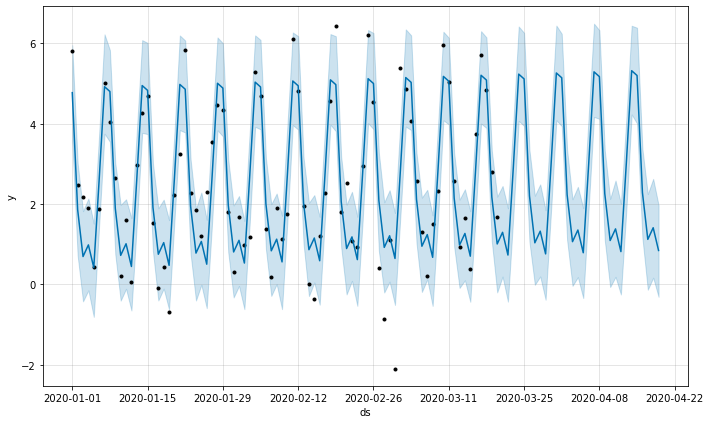

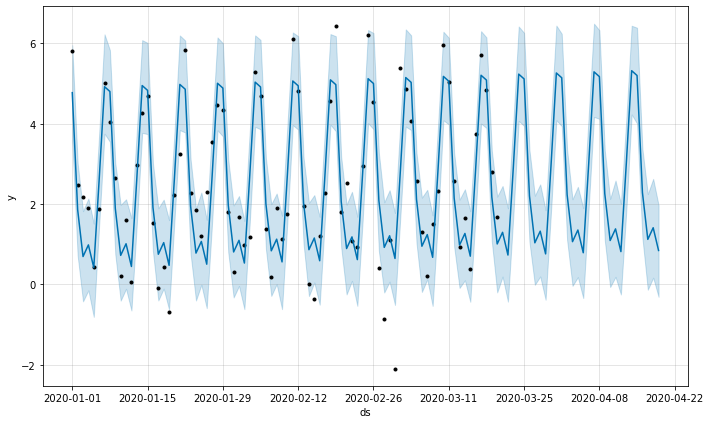

In [39]:
pr_basic.plot(pr_basic_test_fc)

<AxesSubplot:xlabel='ds', ylabel='y'>

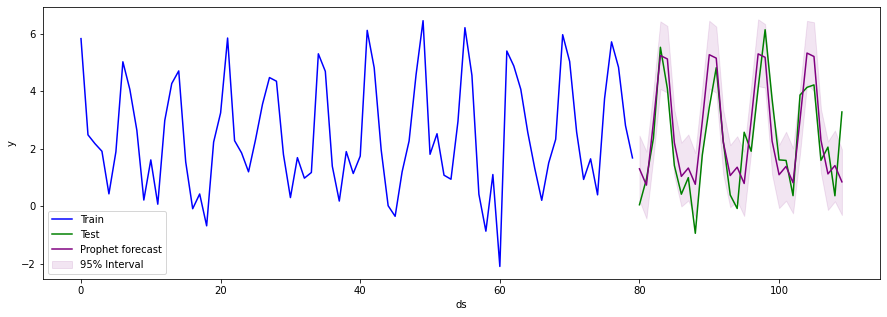

In [40]:
# Plot with prediction intervals
pr_basic_test_fc['ds_ind'] = pr_basic_test_fc.index

plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds', y='y', color='blue', label='Train')
sns.lineplot(data=test, x='ds', y='y', color='green', label='Test')
plt.fill_between(
    x=pr_basic_test_fc[pr_basic_test_fc.ds_ind >= 80]['ds_ind'],
    y1=pr_basic_test_fc[pr_basic_test_fc.ds_ind >= 80]['yhat_lower'],
    y2=pr_basic_test_fc[pr_basic_test_fc.ds_ind >= 80]['yhat_upper'],
    color='purple',
    label='95% Interval',
    alpha=0.1
)
sns.lineplot(data=pr_basic_test_fc[pr_basic_test_fc.ds_ind >= 80], x='ds_ind', y='yhat', color='purple', label='Prophet forecast')

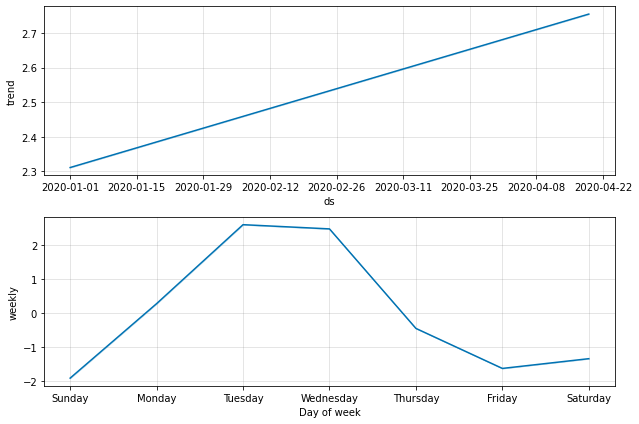

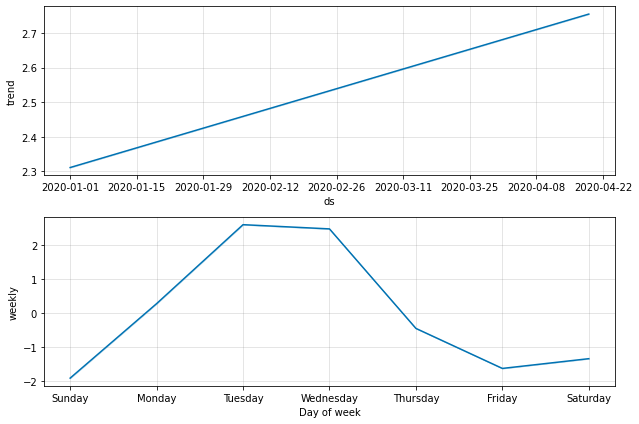

In [41]:
pr_basic.plot_components(pr_basic_test_fc)

C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

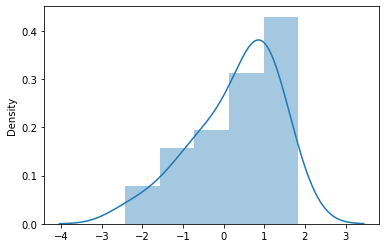

In [42]:
# Distribution of residuals
sns.distplot(pr_basic_test_fc[pr_basic_test_fc.ds_ind >= 80]['yhat'].subtract(test['y']))